In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.emulator import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt


In [2]:
leave_out_box = 'Box0_1400'
print('Leaving out', leave_out_box)

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()

###TMP
# a_list = [a_list[0], a_list[1]]
##TMP


print('alist', a_list)

weird_boxes = ['Box63_1400', 'Box35_1400', 'Box_n50_38_1400', 'Box5_1400']


errors = {a:{} for a in a_list}
X = []
Y = []
Xlo = []
Ylo = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    cosmo_dict = {
        'h': h,
        'Omega_b': curr_cosmo['ombh2'] / h**2,
        'Omega_cdm': curr_cosmo['omch2'] / h**2,
        'N_ur': 0.00641,
        'N_ncdm': 1,
        'output': 'mPk mTk',
        'z_pk': '0.0,99',
        'P_k_max_h/Mpc': 20.,
        'm_ncdm': curr_cosmo['nu_mass_ev']/3,
        'deg_ncdm': 3,
        'T_cmb': 2.7255,
        'A_s': curr_cosmo['10^9 As'] * 10**-9,
        'n_s': curr_cosmo['ns'],
        'Omega_Lambda': 0.0,
        'w0_fld': curr_cosmo['w0'],
        'wa_fld': 0.0,
        'cs2_fld': 1.0,
        'fluid_equation_of_state': "CLP"
    }

    pkclass = Class()
    pkclass.set(cosmo_dict)
    pkclass.compute()

#     mass_function = MassFunction(curr_cosmo)

    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z
        pk_m_lin = np.array(
            [
                pkclass.pk_lin(ki, np.array([z]))*h**3 #units of Mpc^3/h^3
                for ki in kt * h # 1 / Mpc
            ]
        )
        sigma8 = pkclass.sigma(8, z, h_units=True)

#         m8 = mass_function.R_to_M(8, redshiftToScale(z)) #8 h^-1 Mpc as mass
#         sigma8_other = np.exp(mass_function.f_logsigma_logM(z, np.log(m8)))[0][0] #sigma8 at current redshift
#         print(sigma8, sigma8_other)
#         assert(np.abs((sigma8 - sigma8_other)/sigma8) < 1e-3)

        if(leave_out_box == box):
            Xlo += [curr_cosmo_values + [a, sigma8]]
        else:
            X+= [curr_cosmo_values + [a, sigma8]]
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            if(leave_out_box == box):
                Ylo += [param_values]
            else:
                Y+= [param_values]

Leaving out Box0_1400
alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459]


 67%|██████▋   | 101/150 [01:05<00:32,  1.53it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


In [3]:
X = np.array(X)
Y = np.array(Y)
Xlo = np.array(Xlo)
Ylo = np.array(Ylo)
print(Xlo)
print(Ylo)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
Xlo = in_scaler.transform(Xlo)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

[[ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  1.00000000e+00
   7.80353728e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  9.53321000e-01
   7.56670762e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  8.66399000e-01
   7.07697045e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  7.87402000e-01
   6.57663458e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  7.15608000e-01
   6.07833684e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  6.50360000e-01
   5.59294918e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.3311985

In [4]:
X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, amsgrad=True)  # Includes GaussianLikelihood parameters

In [5]:
model.train()
likelihood.train()
# Set initial learning rate
lr = 0.1

# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, amsgrad=True)  # Includes GaussianLikelihood parameters
best_model = None
best_loss = float('inf')

training_iterations = 300
epochs_iter = tqdm(range(training_iterations), desc="Iteration")

Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
    if i == training_iterations//2:
        lr = 0.01
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

Iteration:   0%|          | 1/300 [00:01<08:58,  1.80s/it, loss=2.89]

Iter 1/300 - Loss: 2.8885



Iteration:   1%|          | 2/300 [00:03<09:57,  2.00s/it, loss=2.55]

Iter 2/300 - Loss: 2.5515



Iteration:   1%|          | 3/300 [00:05<09:47,  1.98s/it, loss=2.24]

Iter 3/300 - Loss: 2.2442



Iteration:   1%|▏         | 4/300 [00:07<09:29,  1.93s/it, loss=1.97]

Iter 4/300 - Loss: 1.9693



Iteration:   2%|▏         | 5/300 [00:09<09:18,  1.89s/it, loss=1.73]

Iter 5/300 - Loss: 1.7265



Iteration:   2%|▏         | 6/300 [00:11<09:06,  1.86s/it, loss=1.51]

Iter 6/300 - Loss: 1.5145



Iteration:   2%|▏         | 7/300 [00:13<09:07,  1.87s/it, loss=1.33]

Iter 7/300 - Loss: 1.3336



Iteration:   3%|▎         | 8/300 [00:14<08:51,  1.82s/it, loss=1.19]

Iter 8/300 - Loss: 1.1863



Iteration:   3%|▎         | 9/300 [00:16<08:56,  1.84s/it, loss=1.08]

Iter 9/300 - Loss: 1.0761



Iteration:   3%|▎         | 10/300 [00:18<08:43,  1.81s/it, loss=1]

Iter 10/300 - Loss: 1.0034



Iteration:   4%|▎         | 11/300 [00:20<08:42,  1.81s/it, loss=0.961]

Iter 11/300 - Loss: 0.9609



Iteration:   4%|▍         | 12/300 [00:22<08:52,  1.85s/it, loss=0.936]

Iter 12/300 - Loss: 0.9362



Iteration:   4%|▍         | 13/300 [00:24<08:44,  1.83s/it, loss=0.918]

Iter 13/300 - Loss: 0.9179



Iteration:   5%|▍         | 14/300 [00:26<08:58,  1.88s/it, loss=0.898]

Iter 14/300 - Loss: 0.8977



Iteration:   5%|▌         | 15/300 [00:27<08:49,  1.86s/it, loss=0.871]

Iter 15/300 - Loss: 0.8705



Iteration:   5%|▌         | 16/300 [00:29<08:38,  1.83s/it, loss=0.834]

Iter 16/300 - Loss: 0.8336



Iteration:   6%|▌         | 17/300 [00:32<09:45,  2.07s/it, loss=0.786]

Iter 17/300 - Loss: 0.7858



Iteration:   6%|▌         | 18/300 [00:34<09:19,  1.98s/it, loss=0.728]

Iter 18/300 - Loss: 0.7275



Iteration:   6%|▋         | 19/300 [00:35<08:55,  1.91s/it, loss=0.662]

Iter 19/300 - Loss: 0.6616



Iteration:   7%|▋         | 20/300 [00:37<08:38,  1.85s/it, loss=0.593]

Iter 20/300 - Loss: 0.5925



Iteration:   7%|▋         | 21/300 [00:39<08:30,  1.83s/it, loss=0.525]

Iter 21/300 - Loss: 0.5253



Iteration:   7%|▋         | 22/300 [00:41<08:22,  1.81s/it, loss=0.464]

Iter 22/300 - Loss: 0.4637



Iteration:   8%|▊         | 23/300 [00:42<08:13,  1.78s/it, loss=0.409]

Iter 23/300 - Loss: 0.4091



Iteration:   8%|▊         | 24/300 [00:44<08:06,  1.76s/it, loss=0.361]

Iter 24/300 - Loss: 0.3615



Iteration:   8%|▊         | 25/300 [00:46<08:05,  1.76s/it, loss=0.32]

Iter 25/300 - Loss: 0.3196



Iteration:   9%|▊         | 26/300 [00:48<08:04,  1.77s/it, loss=0.282]

Iter 26/300 - Loss: 0.2815



Iteration:   9%|▉         | 27/300 [00:49<08:02,  1.77s/it, loss=0.245]

Iter 27/300 - Loss: 0.2450



Iteration:   9%|▉         | 28/300 [00:51<08:26,  1.86s/it, loss=0.208]

Iter 28/300 - Loss: 0.2082



Iteration:  10%|▉         | 29/300 [00:53<08:17,  1.83s/it, loss=0.17]

Iter 29/300 - Loss: 0.1700



Iteration:  10%|█         | 30/300 [00:55<08:08,  1.81s/it, loss=0.13]

Iter 30/300 - Loss: 0.1299



Iteration:  10%|█         | 31/300 [00:57<08:00,  1.79s/it, loss=0.0879]

Iter 31/300 - Loss: 0.0879



Iteration:  11%|█         | 32/300 [00:58<07:54,  1.77s/it, loss=0.0443]

Iter 32/300 - Loss: 0.0443



Iteration:  11%|█         | 33/300 [01:00<07:52,  1.77s/it, loss=-.000108]

Iter 33/300 - Loss: -0.0001



Iteration:  11%|█▏        | 34/300 [01:02<07:47,  1.76s/it, loss=-.0445]

Iter 34/300 - Loss: -0.0445



Iteration:  12%|█▏        | 35/300 [01:04<07:48,  1.77s/it, loss=-.088]

Iter 35/300 - Loss: -0.0880



Iteration:  12%|█▏        | 36/300 [01:05<07:44,  1.76s/it, loss=-.13]

Iter 36/300 - Loss: -0.1297



Iteration:  12%|█▏        | 37/300 [01:07<07:40,  1.75s/it, loss=-.169]

Iter 37/300 - Loss: -0.1687



Iteration:  13%|█▎        | 38/300 [01:09<07:37,  1.75s/it, loss=-.204]

Iter 38/300 - Loss: -0.2043



Iteration:  13%|█▎        | 39/300 [01:11<07:35,  1.74s/it, loss=-.237]

Iter 39/300 - Loss: -0.2368



Iteration:  13%|█▎        | 40/300 [01:12<07:34,  1.75s/it, loss=-.267]

Iter 40/300 - Loss: -0.2667



Iteration:  14%|█▎        | 41/300 [01:14<07:33,  1.75s/it, loss=-.294]

Iter 41/300 - Loss: -0.2939



Iteration:  14%|█▍        | 42/300 [01:16<07:37,  1.77s/it, loss=-.32]

Iter 42/300 - Loss: -0.3204



Iteration:  14%|█▍        | 43/300 [01:18<08:03,  1.88s/it, loss=-.347]

Iter 43/300 - Loss: -0.3467



Iteration:  15%|█▍        | 44/300 [01:20<07:51,  1.84s/it, loss=-.373]

Iter 44/300 - Loss: -0.3727



Iteration:  15%|█▌        | 45/300 [01:23<09:53,  2.33s/it, loss=-.399]

Iter 45/300 - Loss: -0.3991



Iteration:  15%|█▌        | 46/300 [01:25<09:06,  2.15s/it, loss=-.425]

Iter 46/300 - Loss: -0.4249



Iteration:  16%|█▌        | 47/300 [01:27<08:33,  2.03s/it, loss=-.449]

Iter 47/300 - Loss: -0.4491



Iteration:  16%|█▌        | 48/300 [01:29<08:09,  1.94s/it, loss=-.472]

Iter 48/300 - Loss: -0.4719



Iteration:  16%|█▋        | 49/300 [01:30<07:52,  1.88s/it, loss=-.493]

Iter 49/300 - Loss: -0.4926



Iteration:  17%|█▋        | 50/300 [01:32<07:39,  1.84s/it, loss=-.511]

Iter 50/300 - Loss: -0.5115



Iteration:  17%|█▋        | 51/300 [01:34<07:31,  1.81s/it, loss=-.528]

Iter 51/300 - Loss: -0.5285



Iteration:  17%|█▋        | 52/300 [01:36<07:25,  1.79s/it, loss=-.544]

Iter 52/300 - Loss: -0.5440



Iteration:  18%|█▊        | 53/300 [01:37<07:20,  1.78s/it, loss=-.558]

Iter 53/300 - Loss: -0.5583



Iteration:  18%|█▊        | 54/300 [01:39<07:16,  1.78s/it, loss=-.572]

Iter 54/300 - Loss: -0.5720



Iteration:  18%|█▊        | 55/300 [01:41<07:14,  1.77s/it, loss=-.585]

Iter 55/300 - Loss: -0.5851



Iteration:  19%|█▊        | 56/300 [01:43<07:10,  1.76s/it, loss=-.598]

Iter 56/300 - Loss: -0.5980



Iteration:  19%|█▉        | 57/300 [01:44<07:06,  1.76s/it, loss=-.611]

Iter 57/300 - Loss: -0.6106



Iteration:  19%|█▉        | 58/300 [01:46<07:05,  1.76s/it, loss=-.623]

Iter 58/300 - Loss: -0.6227



Iteration:  20%|█▉        | 59/300 [01:48<07:03,  1.76s/it, loss=-.634]

Iter 59/300 - Loss: -0.6341



Iteration:  20%|██        | 60/300 [01:50<07:01,  1.76s/it, loss=-.645]

Iter 60/300 - Loss: -0.6448



Iteration:  20%|██        | 61/300 [01:51<07:11,  1.81s/it, loss=-.655]

Iter 61/300 - Loss: -0.6546



Iteration:  21%|██        | 62/300 [01:53<07:06,  1.79s/it, loss=-.664]

Iter 62/300 - Loss: -0.6636



Iteration:  21%|██        | 63/300 [01:55<07:01,  1.78s/it, loss=-.672]

Iter 63/300 - Loss: -0.6721



Iteration:  21%|██▏       | 64/300 [01:57<07:00,  1.78s/it, loss=-.68]

Iter 64/300 - Loss: -0.6801



Iteration:  22%|██▏       | 65/300 [01:59<06:57,  1.78s/it, loss=-.688]

Iter 65/300 - Loss: -0.6877



Iteration:  22%|██▏       | 66/300 [02:00<07:04,  1.82s/it, loss=-.695]

Iter 66/300 - Loss: -0.6949



Iteration:  22%|██▏       | 67/300 [02:02<06:58,  1.80s/it, loss=-.701]

Iter 67/300 - Loss: -0.7011



Iteration:  23%|██▎       | 68/300 [02:04<06:54,  1.79s/it, loss=-.706]

Iter 68/300 - Loss: -0.7063



Iteration:  23%|██▎       | 69/300 [02:06<06:52,  1.79s/it, loss=-.71]

Iter 69/300 - Loss: -0.7104



Iteration:  23%|██▎       | 70/300 [02:08<06:48,  1.78s/it, loss=-.714]

Iter 70/300 - Loss: -0.7138



Iteration:  24%|██▎       | 71/300 [02:09<06:46,  1.78s/it, loss=-.717]

Iter 71/300 - Loss: -0.7167



Iteration:  24%|██▍       | 72/300 [02:11<06:44,  1.77s/it, loss=-.72]

Iter 72/300 - Loss: -0.7195



Iteration:  24%|██▍       | 73/300 [02:13<06:43,  1.78s/it, loss=-.722]

Iter 73/300 - Loss: -0.7223



Iteration:  25%|██▍       | 74/300 [02:15<06:42,  1.78s/it, loss=-.725]

Iter 74/300 - Loss: -0.7249



Iteration:  25%|██▌       | 75/300 [02:16<06:38,  1.77s/it, loss=-.727]

Iter 75/300 - Loss: -0.7272



Iteration:  25%|██▌       | 76/300 [02:18<06:35,  1.77s/it, loss=-.729]

Iter 76/300 - Loss: -0.7292



Iteration:  26%|██▌       | 77/300 [02:20<06:32,  1.76s/it, loss=-.731]

Iter 77/300 - Loss: -0.7306



Iteration:  26%|██▌       | 78/300 [02:22<06:47,  1.83s/it, loss=-.731]

Iter 78/300 - Loss: -0.7314



Iteration:  26%|██▋       | 79/300 [02:24<06:39,  1.81s/it, loss=-.733]

Iter 79/300 - Loss: -0.7332



Iteration:  27%|██▋       | 80/300 [02:26<06:47,  1.85s/it, loss=-.734]

Iter 80/300 - Loss: -0.7338



Iteration:  27%|██▋       | 81/300 [02:27<06:39,  1.82s/it, loss=-.736]

Iter 81/300 - Loss: -0.7361



Iteration:  27%|██▋       | 82/300 [02:29<06:33,  1.81s/it, loss=-.739]

Iter 82/300 - Loss: -0.7391



Iteration:  28%|██▊       | 83/300 [02:31<06:28,  1.79s/it, loss=-.739]

Iter 83/300 - Loss: -0.7392



Iteration:  28%|██▊       | 84/300 [02:33<06:23,  1.77s/it, loss=-.742]

Iter 84/300 - Loss: -0.7416



Iteration:  28%|██▊       | 85/300 [02:34<06:20,  1.77s/it, loss=-.742]

Iter 85/300 - Loss: -0.7418



Iteration:  29%|██▊       | 86/300 [02:36<06:17,  1.76s/it, loss=-.744]

Iter 86/300 - Loss: -0.7436



Iteration:  29%|██▉       | 87/300 [02:38<06:14,  1.76s/it, loss=-.744]

Iter 87/300 - Loss: -0.7438



Iteration:  29%|██▉       | 88/300 [02:40<06:11,  1.75s/it, loss=-.746]

Iter 88/300 - Loss: -0.7457



Iteration:  30%|██▉       | 89/300 [02:41<06:09,  1.75s/it, loss=-.746]

Iter 89/300 - Loss: -0.7458



Iteration:  30%|███       | 90/300 [02:43<06:07,  1.75s/it, loss=-.747]

Iter 90/300 - Loss: -0.7474



Iteration:  30%|███       | 91/300 [02:45<06:05,  1.75s/it, loss=-.748]

Iter 91/300 - Loss: -0.7477



Iteration:  31%|███       | 92/300 [02:47<06:04,  1.75s/it, loss=-.749]

Iter 92/300 - Loss: -0.7488



Iteration:  31%|███       | 93/300 [02:48<06:02,  1.75s/it, loss=-.749]

Iter 93/300 - Loss: -0.7493



Iteration:  31%|███▏      | 94/300 [02:50<06:00,  1.75s/it, loss=-.75]

Iter 94/300 - Loss: -0.7502



Iteration:  32%|███▏      | 95/300 [02:52<06:09,  1.80s/it, loss=-.751]

Iter 95/300 - Loss: -0.7508



Iteration:  32%|███▏      | 96/300 [02:54<06:11,  1.82s/it, loss=-.751]

Iter 96/300 - Loss: -0.7515



Iteration:  32%|███▏      | 97/300 [02:56<06:05,  1.80s/it, loss=-.752]

Iter 97/300 - Loss: -0.7520



Iteration:  33%|███▎      | 98/300 [02:57<06:00,  1.79s/it, loss=-.753]

Iter 98/300 - Loss: -0.7525



Iteration:  33%|███▎      | 99/300 [02:59<06:00,  1.79s/it, loss=-.753]

Iter 99/300 - Loss: -0.7530



Iteration:  33%|███▎      | 100/300 [03:01<05:58,  1.79s/it, loss=-.753]

Iter 100/300 - Loss: -0.7533



Iteration:  34%|███▎      | 101/300 [03:03<05:58,  1.80s/it, loss=-.754]

Iter 101/300 - Loss: -0.7539



Iteration:  34%|███▍      | 102/300 [03:05<05:54,  1.79s/it, loss=-.754]

Iter 102/300 - Loss: -0.7542



Iteration:  34%|███▍      | 103/300 [03:06<05:50,  1.78s/it, loss=-.755]

Iter 103/300 - Loss: -0.7548



Iteration:  35%|███▍      | 104/300 [03:08<05:47,  1.77s/it, loss=-.755]

Iter 104/300 - Loss: -0.7551



Iteration:  35%|███▌      | 105/300 [03:10<05:45,  1.77s/it, loss=-.756]

Iter 105/300 - Loss: -0.7556



Iteration:  35%|███▌      | 106/300 [03:12<05:42,  1.77s/it, loss=-.756]

Iter 106/300 - Loss: -0.7559



Iteration:  36%|███▌      | 107/300 [03:13<05:40,  1.77s/it, loss=-.756]

Iter 107/300 - Loss: -0.7564



Iteration:  36%|███▌      | 108/300 [03:15<05:38,  1.77s/it, loss=-.757]

Iter 108/300 - Loss: -0.7567



Iteration:  36%|███▋      | 109/300 [03:17<05:36,  1.76s/it, loss=-.757]

Iter 109/300 - Loss: -0.7571



Iteration:  37%|███▋      | 110/300 [03:19<05:35,  1.76s/it, loss=-.757]

Iter 110/300 - Loss: -0.7575



Iteration:  37%|███▋      | 111/300 [03:20<05:32,  1.76s/it, loss=-.758]

Iter 111/300 - Loss: -0.7579



Iteration:  37%|███▋      | 112/300 [03:23<06:00,  1.92s/it, loss=-.758]

Iter 112/300 - Loss: -0.7582



Iteration:  38%|███▊      | 113/300 [03:24<05:49,  1.87s/it, loss=-.759]

Iter 113/300 - Loss: -0.7586



Iteration:  38%|███▊      | 114/300 [03:26<05:41,  1.83s/it, loss=-.759]

Iter 114/300 - Loss: -0.7589



Iteration:  38%|███▊      | 115/300 [03:28<05:34,  1.81s/it, loss=-.759]

Iter 115/300 - Loss: -0.7593



Iteration:  39%|███▊      | 116/300 [03:30<05:30,  1.79s/it, loss=-.76]

Iter 116/300 - Loss: -0.7596



Iteration:  39%|███▉      | 117/300 [03:31<05:25,  1.78s/it, loss=-.76]

Iter 117/300 - Loss: -0.7600



Iteration:  39%|███▉      | 118/300 [03:33<05:21,  1.77s/it, loss=-.76]

Iter 118/300 - Loss: -0.7603



Iteration:  40%|███▉      | 119/300 [03:35<05:19,  1.77s/it, loss=-.761]

Iter 119/300 - Loss: -0.7607



Iteration:  40%|████      | 120/300 [03:37<05:16,  1.76s/it, loss=-.761]

Iter 120/300 - Loss: -0.7610



Iteration:  40%|████      | 121/300 [03:38<05:14,  1.76s/it, loss=-.761]

Iter 121/300 - Loss: -0.7614



Iteration:  41%|████      | 122/300 [03:40<05:12,  1.76s/it, loss=-.762]

Iter 122/300 - Loss: -0.7617



Iteration:  41%|████      | 123/300 [03:42<05:10,  1.75s/it, loss=-.762]

Iter 123/300 - Loss: -0.7620



Iteration:  41%|████▏     | 124/300 [03:44<05:08,  1.75s/it, loss=-.762]

Iter 124/300 - Loss: -0.7623



Iteration:  42%|████▏     | 125/300 [03:45<05:07,  1.75s/it, loss=-.763]

Iter 125/300 - Loss: -0.7627



Iteration:  42%|████▏     | 126/300 [03:47<05:05,  1.76s/it, loss=-.763]

Iter 126/300 - Loss: -0.7630



Iteration:  42%|████▏     | 127/300 [03:49<05:03,  1.75s/it, loss=-.763]

Iter 127/300 - Loss: -0.7633



Iteration:  43%|████▎     | 128/300 [03:51<05:03,  1.76s/it, loss=-.764]

Iter 128/300 - Loss: -0.7636



Iteration:  43%|████▎     | 129/300 [03:53<05:01,  1.77s/it, loss=-.764]

Iter 129/300 - Loss: -0.7639



Iteration:  43%|████▎     | 130/300 [03:54<04:59,  1.76s/it, loss=-.764]

Iter 130/300 - Loss: -0.7642



Iteration:  44%|████▎     | 131/300 [03:56<04:57,  1.76s/it, loss=-.765]

Iter 131/300 - Loss: -0.7645



Iteration:  44%|████▍     | 132/300 [03:58<04:54,  1.75s/it, loss=-.765]

Iter 132/300 - Loss: -0.7648



Iteration:  44%|████▍     | 133/300 [04:00<04:52,  1.75s/it, loss=-.765]

Iter 133/300 - Loss: -0.7651



Iteration:  45%|████▍     | 134/300 [04:01<04:50,  1.75s/it, loss=-.765]

Iter 134/300 - Loss: -0.7654



Iteration:  45%|████▌     | 135/300 [04:03<04:48,  1.75s/it, loss=-.766]

Iter 135/300 - Loss: -0.7657



Iteration:  45%|████▌     | 136/300 [04:05<04:46,  1.75s/it, loss=-.766]

Iter 136/300 - Loss: -0.7660



Iteration:  46%|████▌     | 137/300 [04:06<04:44,  1.74s/it, loss=-.766]

Iter 137/300 - Loss: -0.7663



Iteration:  46%|████▌     | 138/300 [04:08<04:42,  1.74s/it, loss=-.767]

Iter 138/300 - Loss: -0.7667



Iteration:  46%|████▋     | 139/300 [04:10<04:47,  1.79s/it, loss=-.767]

Iter 139/300 - Loss: -0.7670



Iteration:  47%|████▋     | 140/300 [04:12<04:43,  1.77s/it, loss=-.767]

Iter 140/300 - Loss: -0.7674



Iteration:  47%|████▋     | 141/300 [04:14<04:41,  1.77s/it, loss=-.768]

Iter 141/300 - Loss: -0.7678



Iteration:  47%|████▋     | 142/300 [04:15<04:38,  1.76s/it, loss=-.768]

Iter 142/300 - Loss: -0.7683



Iteration:  48%|████▊     | 143/300 [04:17<04:36,  1.76s/it, loss=-.769]

Iter 143/300 - Loss: -0.7689



Iteration:  48%|████▊     | 144/300 [04:19<04:33,  1.76s/it, loss=-.77]

Iter 144/300 - Loss: -0.7695



Iteration:  48%|████▊     | 145/300 [04:21<04:38,  1.80s/it, loss=-.77]

Iter 145/300 - Loss: -0.7703



Iteration:  49%|████▊     | 146/300 [04:22<04:34,  1.78s/it, loss=-.771]

Iter 146/300 - Loss: -0.7712



Iteration:  49%|████▉     | 147/300 [04:24<04:35,  1.80s/it, loss=-.772]

Iter 147/300 - Loss: -0.7722



Iteration:  49%|████▉     | 148/300 [04:26<04:30,  1.78s/it, loss=-.773]

Iter 148/300 - Loss: -0.7734



Iteration:  50%|████▉     | 149/300 [04:28<04:28,  1.78s/it, loss=-.775]

Iter 149/300 - Loss: -0.7747



Iteration:  50%|█████     | 150/300 [04:30<04:25,  1.77s/it, loss=-.776]

Iter 150/300 - Loss: -0.7757



Iteration:  50%|█████     | 151/300 [04:31<04:23,  1.77s/it, loss=-.777]

Iter 151/300 - Loss: -0.7768



Iteration:  51%|█████     | 152/300 [04:33<04:20,  1.76s/it, loss=-.779]

Iter 152/300 - Loss: -0.7793



Iteration:  51%|█████     | 153/300 [04:35<04:18,  1.76s/it, loss=-.78]

Iter 153/300 - Loss: -0.7798



Iteration:  51%|█████▏    | 154/300 [04:37<04:16,  1.76s/it, loss=-.781]

Iter 154/300 - Loss: -0.7808



Iteration:  52%|█████▏    | 155/300 [04:39<04:27,  1.84s/it, loss=-.781]

Iter 155/300 - Loss: -0.7814



Iteration:  52%|█████▏    | 156/300 [04:41<04:27,  1.86s/it, loss=-.781]

Iter 156/300 - Loss: -0.7815



Iteration:  52%|█████▏    | 157/300 [04:42<04:20,  1.83s/it, loss=-.781]

Iter 157/300 - Loss: -0.7813



Iteration:  53%|█████▎    | 158/300 [04:44<04:17,  1.81s/it, loss=-.782]

Iter 158/300 - Loss: -0.7815



Iteration:  53%|█████▎    | 159/300 [04:46<04:13,  1.80s/it, loss=-.782]

Iter 159/300 - Loss: -0.7821



Iteration:  53%|█████▎    | 160/300 [04:48<04:09,  1.78s/it, loss=-.783]

Iter 160/300 - Loss: -0.7828



Iteration:  54%|█████▎    | 161/300 [04:49<04:06,  1.77s/it, loss=-.783]

Iter 161/300 - Loss: -0.7832



Iteration:  54%|█████▍    | 162/300 [04:51<04:05,  1.78s/it, loss=-.783]

Iter 162/300 - Loss: -0.7834



Iteration:  54%|█████▍    | 163/300 [04:53<04:12,  1.84s/it, loss=-.784]

Iter 163/300 - Loss: -0.7835



Iteration:  55%|█████▍    | 164/300 [04:55<04:07,  1.82s/it, loss=-.784]

Iter 164/300 - Loss: -0.7838



Iteration:  55%|█████▌    | 165/300 [04:57<04:02,  1.80s/it, loss=-.784]

Iter 165/300 - Loss: -0.7843



Iteration:  55%|█████▌    | 166/300 [04:58<03:58,  1.78s/it, loss=-.785]

Iter 166/300 - Loss: -0.7848



Iteration:  56%|█████▌    | 167/300 [05:00<03:56,  1.78s/it, loss=-.785]

Iter 167/300 - Loss: -0.7852



Iteration:  56%|█████▌    | 168/300 [05:02<03:53,  1.77s/it, loss=-.785]

Iter 168/300 - Loss: -0.7855



Iteration:  56%|█████▋    | 169/300 [05:04<03:51,  1.76s/it, loss=-.786]

Iter 169/300 - Loss: -0.7857



Iteration:  57%|█████▋    | 170/300 [05:05<03:49,  1.76s/it, loss=-.786]

Iter 170/300 - Loss: -0.7861



Iteration:  57%|█████▋    | 171/300 [05:07<03:48,  1.77s/it, loss=-.786]

Iter 171/300 - Loss: -0.7865



Iteration:  57%|█████▋    | 172/300 [05:09<03:46,  1.77s/it, loss=-.787]

Iter 172/300 - Loss: -0.7869



Iteration:  58%|█████▊    | 173/300 [05:11<03:43,  1.76s/it, loss=-.787]

Iter 173/300 - Loss: -0.7872



Iteration:  58%|█████▊    | 174/300 [05:12<03:42,  1.77s/it, loss=-.788]

Iter 174/300 - Loss: -0.7875



Iteration:  58%|█████▊    | 175/300 [05:14<03:41,  1.77s/it, loss=-.788]

Iter 175/300 - Loss: -0.7878



Iteration:  59%|█████▊    | 176/300 [05:16<03:39,  1.77s/it, loss=-.788]

Iter 176/300 - Loss: -0.7881



Iteration:  59%|█████▉    | 177/300 [05:18<03:36,  1.76s/it, loss=-.788]

Iter 177/300 - Loss: -0.7885



Iteration:  59%|█████▉    | 178/300 [05:20<03:34,  1.76s/it, loss=-.789]

Iter 178/300 - Loss: -0.7888



Iteration:  60%|█████▉    | 179/300 [05:21<03:37,  1.80s/it, loss=-.789]

Iter 179/300 - Loss: -0.7891



Iteration:  60%|██████    | 180/300 [05:23<03:33,  1.78s/it, loss=-.789]

Iter 180/300 - Loss: -0.7894



Iteration:  60%|██████    | 181/300 [05:25<03:30,  1.77s/it, loss=-.79]

Iter 181/300 - Loss: -0.7897



Iteration:  61%|██████    | 182/300 [05:27<03:28,  1.76s/it, loss=-.79]

Iter 182/300 - Loss: -0.7900



Iteration:  61%|██████    | 183/300 [05:28<03:26,  1.76s/it, loss=-.79]

Iter 183/300 - Loss: -0.7903



Iteration:  61%|██████▏   | 184/300 [05:30<03:24,  1.76s/it, loss=-.791]

Iter 184/300 - Loss: -0.7906



Iteration:  62%|██████▏   | 185/300 [05:32<03:22,  1.76s/it, loss=-.791]

Iter 185/300 - Loss: -0.7909



Iteration:  62%|██████▏   | 186/300 [05:34<03:20,  1.76s/it, loss=-.791]

Iter 186/300 - Loss: -0.7912



Iteration:  62%|██████▏   | 187/300 [05:35<03:18,  1.76s/it, loss=-.791]

Iter 187/300 - Loss: -0.7914



Iteration:  63%|██████▎   | 188/300 [05:37<03:17,  1.76s/it, loss=-.792]

Iter 188/300 - Loss: -0.7917



Iteration:  63%|██████▎   | 189/300 [05:39<03:15,  1.76s/it, loss=-.792]

Iter 189/300 - Loss: -0.7920



Iteration:  63%|██████▎   | 190/300 [05:41<03:14,  1.76s/it, loss=-.792]

Iter 190/300 - Loss: -0.7922



Iteration:  64%|██████▎   | 191/300 [05:43<03:12,  1.77s/it, loss=-.792]

Iter 191/300 - Loss: -0.7925



Iteration:  64%|██████▍   | 192/300 [05:44<03:10,  1.76s/it, loss=-.793]

Iter 192/300 - Loss: -0.7927



Iteration:  64%|██████▍   | 193/300 [05:46<03:08,  1.76s/it, loss=-.793]

Iter 193/300 - Loss: -0.7930



Iteration:  65%|██████▍   | 194/300 [05:48<03:06,  1.76s/it, loss=-.793]

Iter 194/300 - Loss: -0.7932



Iteration:  65%|██████▌   | 195/300 [05:50<03:05,  1.76s/it, loss=-.793]

Iter 195/300 - Loss: -0.7934



Iteration:  65%|██████▌   | 196/300 [05:52<03:10,  1.83s/it, loss=-.794]

Iter 196/300 - Loss: -0.7937



Iteration:  66%|██████▌   | 197/300 [05:53<03:09,  1.84s/it, loss=-.794]

Iter 197/300 - Loss: -0.7939



Iteration:  66%|██████▌   | 198/300 [05:55<03:05,  1.82s/it, loss=-.794]

Iter 198/300 - Loss: -0.7941



Iteration:  66%|██████▋   | 199/300 [05:57<03:01,  1.79s/it, loss=-.794]

Iter 199/300 - Loss: -0.7943



Iteration:  67%|██████▋   | 200/300 [05:59<02:57,  1.78s/it, loss=-.795]

Iter 200/300 - Loss: -0.7946



Iteration:  67%|██████▋   | 201/300 [06:01<03:03,  1.85s/it, loss=-.795]

Iter 201/300 - Loss: -0.7948



Iteration:  67%|██████▋   | 202/300 [06:02<02:58,  1.82s/it, loss=-.795]

Iter 202/300 - Loss: -0.7950



Iteration:  68%|██████▊   | 203/300 [06:04<02:54,  1.80s/it, loss=-.795]

Iter 203/300 - Loss: -0.7952



Iteration:  68%|██████▊   | 204/300 [06:06<02:51,  1.79s/it, loss=-.795]

Iter 204/300 - Loss: -0.7954



Iteration:  68%|██████▊   | 205/300 [06:08<02:51,  1.80s/it, loss=-.796]

Iter 205/300 - Loss: -0.7956



Iteration:  69%|██████▊   | 206/300 [06:10<02:50,  1.81s/it, loss=-.796]

Iter 206/300 - Loss: -0.7958



Iteration:  69%|██████▉   | 207/300 [06:12<02:55,  1.89s/it, loss=-.796]

Iter 207/300 - Loss: -0.7959



Iteration:  69%|██████▉   | 208/300 [06:13<02:50,  1.86s/it, loss=-.796]

Iter 208/300 - Loss: -0.7961



Iteration:  70%|██████▉   | 209/300 [06:15<02:45,  1.82s/it, loss=-.796]

Iter 209/300 - Loss: -0.7963



Iteration:  70%|███████   | 210/300 [06:17<02:41,  1.80s/it, loss=-.796]

Iter 210/300 - Loss: -0.7965



Iteration:  70%|███████   | 211/300 [06:19<02:38,  1.78s/it, loss=-.797]

Iter 211/300 - Loss: -0.7967



Iteration:  71%|███████   | 212/300 [06:20<02:36,  1.78s/it, loss=-.797]

Iter 212/300 - Loss: -0.7968



Iteration:  71%|███████   | 213/300 [06:22<02:36,  1.79s/it, loss=-.797]

Iter 213/300 - Loss: -0.7970



Iteration:  71%|███████▏  | 214/300 [06:24<02:32,  1.78s/it, loss=-.797]

Iter 214/300 - Loss: -0.7972



Iteration:  72%|███████▏  | 215/300 [06:26<02:30,  1.77s/it, loss=-.797]

Iter 215/300 - Loss: -0.7973



Iteration:  72%|███████▏  | 216/300 [06:28<02:28,  1.76s/it, loss=-.797]

Iter 216/300 - Loss: -0.7975



Iteration:  72%|███████▏  | 217/300 [06:29<02:25,  1.76s/it, loss=-.798]

Iter 217/300 - Loss: -0.7976



Iteration:  73%|███████▎  | 218/300 [06:31<02:24,  1.76s/it, loss=-.798]

Iter 218/300 - Loss: -0.7978



Iteration:  73%|███████▎  | 219/300 [06:33<02:22,  1.76s/it, loss=-.798]

Iter 219/300 - Loss: -0.7979



Iteration:  73%|███████▎  | 220/300 [06:35<02:20,  1.76s/it, loss=-.798]

Iter 220/300 - Loss: -0.7981



Iteration:  74%|███████▎  | 221/300 [06:36<02:18,  1.76s/it, loss=-.798]

Iter 221/300 - Loss: -0.7982



Iteration:  74%|███████▍  | 222/300 [06:38<02:16,  1.75s/it, loss=-.798]

Iter 222/300 - Loss: -0.7984



Iteration:  74%|███████▍  | 223/300 [06:40<02:14,  1.75s/it, loss=-.799]

Iter 223/300 - Loss: -0.7985



Iteration:  75%|███████▍  | 224/300 [06:42<02:12,  1.75s/it, loss=-.799]

Iter 224/300 - Loss: -0.7986



Iteration:  75%|███████▌  | 225/300 [06:43<02:11,  1.76s/it, loss=-.799]

Iter 225/300 - Loss: -0.7988



Iteration:  75%|███████▌  | 226/300 [06:45<02:09,  1.75s/it, loss=-.799]

Iter 226/300 - Loss: -0.7989



Iteration:  76%|███████▌  | 227/300 [06:47<02:07,  1.75s/it, loss=-.799]

Iter 227/300 - Loss: -0.7990



Iteration:  76%|███████▌  | 228/300 [06:49<02:05,  1.75s/it, loss=-.799]

Iter 228/300 - Loss: -0.7992



Iteration:  76%|███████▋  | 229/300 [06:50<02:04,  1.75s/it, loss=-.799]

Iter 229/300 - Loss: -0.7993



Iteration:  77%|███████▋  | 230/300 [06:52<02:07,  1.82s/it, loss=-.799]

Iter 230/300 - Loss: -0.7994



Iteration:  77%|███████▋  | 231/300 [06:54<02:04,  1.80s/it, loss=-.8]

Iter 231/300 - Loss: -0.7996



Iteration:  77%|███████▋  | 232/300 [06:56<02:01,  1.78s/it, loss=-.8]

Iter 232/300 - Loss: -0.7997



Iteration:  78%|███████▊  | 233/300 [06:58<01:58,  1.77s/it, loss=-.8]

Iter 233/300 - Loss: -0.7998



Iteration:  78%|███████▊  | 234/300 [06:59<01:57,  1.78s/it, loss=-.8]

Iter 234/300 - Loss: -0.7999



Iteration:  78%|███████▊  | 235/300 [07:01<01:56,  1.79s/it, loss=-.8]

Iter 235/300 - Loss: -0.8000



Iteration:  79%|███████▊  | 236/300 [07:03<01:54,  1.78s/it, loss=-.8]

Iter 236/300 - Loss: -0.8002



Iteration:  79%|███████▉  | 237/300 [07:05<01:52,  1.79s/it, loss=-.8]

Iter 237/300 - Loss: -0.8003



Iteration:  79%|███████▉  | 238/300 [07:06<01:50,  1.78s/it, loss=-.8]

Iter 238/300 - Loss: -0.8004



Iteration:  80%|███████▉  | 239/300 [07:08<01:48,  1.77s/it, loss=-.8]

Iter 239/300 - Loss: -0.8005



Iteration:  80%|████████  | 240/300 [07:10<01:46,  1.77s/it, loss=-.801]

Iter 240/300 - Loss: -0.8006



Iteration:  80%|████████  | 241/300 [07:12<01:44,  1.77s/it, loss=-.801]

Iter 241/300 - Loss: -0.8007



Iteration:  81%|████████  | 242/300 [07:14<01:42,  1.77s/it, loss=-.801]

Iter 242/300 - Loss: -0.8008



Iteration:  81%|████████  | 243/300 [07:15<01:40,  1.76s/it, loss=-.801]

Iter 243/300 - Loss: -0.8009



Iteration:  81%|████████▏ | 244/300 [07:17<01:38,  1.77s/it, loss=-.801]

Iter 244/300 - Loss: -0.8010



Iteration:  82%|████████▏ | 245/300 [07:19<01:37,  1.76s/it, loss=-.801]

Iter 245/300 - Loss: -0.8011



Iteration:  82%|████████▏ | 246/300 [07:21<01:38,  1.82s/it, loss=-.801]

Iter 246/300 - Loss: -0.8012



Iteration:  82%|████████▏ | 247/300 [07:23<01:37,  1.85s/it, loss=-.801]

Iter 247/300 - Loss: -0.8013



Iteration:  83%|████████▎ | 248/300 [07:25<01:35,  1.84s/it, loss=-.801]

Iter 248/300 - Loss: -0.8014



Iteration:  83%|████████▎ | 249/300 [07:26<01:32,  1.82s/it, loss=-.802]

Iter 249/300 - Loss: -0.8015



Iteration:  83%|████████▎ | 250/300 [07:28<01:29,  1.80s/it, loss=-.802]

Iter 250/300 - Loss: -0.8016



Iteration:  84%|████████▎ | 251/300 [07:30<01:27,  1.79s/it, loss=-.802]

Iter 251/300 - Loss: -0.8017



Iteration:  84%|████████▍ | 252/300 [07:32<01:25,  1.78s/it, loss=-.802]

Iter 252/300 - Loss: -0.8018



Iteration:  84%|████████▍ | 253/300 [07:33<01:23,  1.77s/it, loss=-.802]

Iter 253/300 - Loss: -0.8019



Iteration:  85%|████████▍ | 254/300 [07:35<01:21,  1.77s/it, loss=-.802]

Iter 254/300 - Loss: -0.8020



Iteration:  85%|████████▌ | 255/300 [07:37<01:20,  1.80s/it, loss=-.802]

Iter 255/300 - Loss: -0.8021



Iteration:  85%|████████▌ | 256/300 [07:39<01:18,  1.78s/it, loss=-.802]

Iter 256/300 - Loss: -0.8022



Iteration:  86%|████████▌ | 257/300 [07:41<01:17,  1.80s/it, loss=-.802]

Iter 257/300 - Loss: -0.8023



Iteration:  86%|████████▌ | 258/300 [07:42<01:16,  1.82s/it, loss=-.802]

Iter 258/300 - Loss: -0.8024



Iteration:  86%|████████▋ | 259/300 [07:44<01:13,  1.80s/it, loss=-.802]

Iter 259/300 - Loss: -0.8025



Iteration:  87%|████████▋ | 260/300 [07:46<01:11,  1.79s/it, loss=-.803]

Iter 260/300 - Loss: -0.8025



Iteration:  87%|████████▋ | 261/300 [07:48<01:09,  1.78s/it, loss=-.803]

Iter 261/300 - Loss: -0.8026



Iteration:  87%|████████▋ | 262/300 [07:49<01:07,  1.78s/it, loss=-.803]

Iter 262/300 - Loss: -0.8027



Iteration:  88%|████████▊ | 263/300 [07:51<01:06,  1.79s/it, loss=-.803]

Iter 263/300 - Loss: -0.8028



Iteration:  88%|████████▊ | 264/300 [07:53<01:04,  1.78s/it, loss=-.803]

Iter 264/300 - Loss: -0.8029



Iteration:  88%|████████▊ | 265/300 [07:56<01:12,  2.06s/it, loss=-.803]

Iter 265/300 - Loss: -0.8030



Iteration:  89%|████████▊ | 266/300 [07:57<01:06,  1.97s/it, loss=-.803]

Iter 266/300 - Loss: -0.8030



Iteration:  89%|████████▉ | 267/300 [07:59<01:03,  1.92s/it, loss=-.803]

Iter 267/300 - Loss: -0.8031



Iteration:  89%|████████▉ | 268/300 [08:01<01:03,  1.97s/it, loss=-.803]

Iter 268/300 - Loss: -0.8032



Iteration:  90%|████████▉ | 269/300 [08:03<01:02,  2.01s/it, loss=-.803]

Iter 269/300 - Loss: -0.8033



Iteration:  90%|█████████ | 270/300 [08:05<00:57,  1.93s/it, loss=-.803]

Iter 270/300 - Loss: -0.8034



Iteration:  90%|█████████ | 271/300 [08:07<00:54,  1.89s/it, loss=-.803]

Iter 271/300 - Loss: -0.8035



Iteration:  91%|█████████ | 272/300 [08:10<01:00,  2.15s/it, loss=-.804]

Iter 272/300 - Loss: -0.8035



Iteration:  91%|█████████ | 273/300 [08:12<00:59,  2.20s/it, loss=-.804]

Iter 273/300 - Loss: -0.8036



Iteration:  91%|█████████▏| 274/300 [08:14<00:53,  2.07s/it, loss=-.804]

Iter 274/300 - Loss: -0.8037



Iteration:  92%|█████████▏| 275/300 [08:16<00:49,  1.98s/it, loss=-.804]

Iter 275/300 - Loss: -0.8038



Iteration:  92%|█████████▏| 276/300 [08:17<00:45,  1.91s/it, loss=-.804]

Iter 276/300 - Loss: -0.8038



Iteration:  92%|█████████▏| 277/300 [08:19<00:42,  1.86s/it, loss=-.804]

Iter 277/300 - Loss: -0.8039



Iteration:  93%|█████████▎| 278/300 [08:21<00:41,  1.88s/it, loss=-.804]

Iter 278/300 - Loss: -0.8040



Iteration:  93%|█████████▎| 279/300 [08:23<00:38,  1.84s/it, loss=-.804]

Iter 279/300 - Loss: -0.8041



Iteration:  93%|█████████▎| 280/300 [08:25<00:36,  1.81s/it, loss=-.804]

Iter 280/300 - Loss: -0.8041



Iteration:  94%|█████████▎| 281/300 [08:26<00:34,  1.80s/it, loss=-.804]

Iter 281/300 - Loss: -0.8042



Iteration:  94%|█████████▍| 282/300 [08:28<00:32,  1.81s/it, loss=-.804]

Iter 282/300 - Loss: -0.8043



Iteration:  94%|█████████▍| 283/300 [08:30<00:30,  1.80s/it, loss=-.804]

Iter 283/300 - Loss: -0.8044



Iteration:  95%|█████████▍| 284/300 [08:32<00:28,  1.80s/it, loss=-.804]

Iter 284/300 - Loss: -0.8044



Iteration:  95%|█████████▌| 285/300 [08:33<00:26,  1.79s/it, loss=-.805]

Iter 285/300 - Loss: -0.8045



Iteration:  95%|█████████▌| 286/300 [08:35<00:24,  1.78s/it, loss=-.805]

Iter 286/300 - Loss: -0.8046



Iteration:  96%|█████████▌| 287/300 [08:37<00:22,  1.77s/it, loss=-.805]

Iter 287/300 - Loss: -0.8047



Iteration:  96%|█████████▌| 288/300 [08:39<00:21,  1.76s/it, loss=-.805]

Iter 288/300 - Loss: -0.8047



Iteration:  96%|█████████▋| 289/300 [08:41<00:19,  1.77s/it, loss=-.805]

Iter 289/300 - Loss: -0.8048



Iteration:  97%|█████████▋| 290/300 [08:42<00:17,  1.78s/it, loss=-.805]

Iter 290/300 - Loss: -0.8049



Iteration:  97%|█████████▋| 291/300 [08:44<00:16,  1.79s/it, loss=-.805]

Iter 291/300 - Loss: -0.8050



Iteration:  97%|█████████▋| 292/300 [08:46<00:14,  1.79s/it, loss=-.805]

Iter 292/300 - Loss: -0.8050



Iteration:  98%|█████████▊| 293/300 [08:48<00:12,  1.77s/it, loss=-.805]

Iter 293/300 - Loss: -0.8051



Iteration:  98%|█████████▊| 294/300 [08:49<00:10,  1.77s/it, loss=-.805]

Iter 294/300 - Loss: -0.8052



Iteration:  98%|█████████▊| 295/300 [08:52<00:09,  1.88s/it, loss=-.805]

Iter 295/300 - Loss: -0.8052



Iteration:  99%|█████████▊| 296/300 [08:53<00:07,  1.84s/it, loss=-.805]

Iter 296/300 - Loss: -0.8053



Iteration:  99%|█████████▉| 297/300 [08:55<00:05,  1.82s/it, loss=-.805]

Iter 297/300 - Loss: -0.8054



Iteration:  99%|█████████▉| 298/300 [08:57<00:03,  1.80s/it, loss=-.805]

Iter 298/300 - Loss: -0.8055



Iteration: 100%|█████████▉| 299/300 [08:59<00:01,  1.80s/it, loss=-.806]

Iter 299/300 - Loss: -0.8055



Iteration: 100%|██████████| 300/300 [09:00<00:00,  1.80s/it, loss=-.806]

Iter 300/300 - Loss: -0.8056


In [7]:
from aemulusnu_massfunction.massfunction import *

with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box), "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)






Emulator = AemulusNu_HMF_Emulator(emulator_loc = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box))

In [8]:
box =leave_out_box
from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]

100%|██████████| 14/14 [00:00<00:00, 42275.20it/s]


In [9]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}
for c_X, c_Y, a in zip(Xlo, Ylo, a_list):
    true_params[a] = c_Y

In [10]:
print(Emulator.predict_params(cosmo_params[leave_out_box], scaleToRedshift(1.0)))
print(true_params[1.0])

Setting dictionary
Computing sigma spline
Initializing CLASS
Computing Sigma from CLASS


100%|██████████| 100/100 [00:01<00:00, 51.33it/s]


Spline Made
{'d': 0.5224220879953957, 'e': 1.0433619982327245, 'f': 2.340718498041674, 'g': 1.31601301587239}
[0.52366994 1.09547607 2.3437498  1.3182055 ]


In [11]:
X[-1]

array([0.43346427, 0.51837394, 0.68303941, 0.41289957, 0.72732097,
       0.47352854, 0.00095261, 0.        , 0.16461492])

In [12]:
print(Emulator.predict_params(cosmo_params['Box_n50_0_1400'], scaleToRedshift(1.0)))

Setting dictionary
Computing sigma spline
Initializing CLASS
Computing Sigma from CLASS


100%|██████████| 100/100 [00:01<00:00, 51.40it/s]


Spline Made
{'d': 0.5417111131707707, 'e': 1.191662970487285, 'f': 2.3445120012664176, 'g': 1.284425740130606}


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


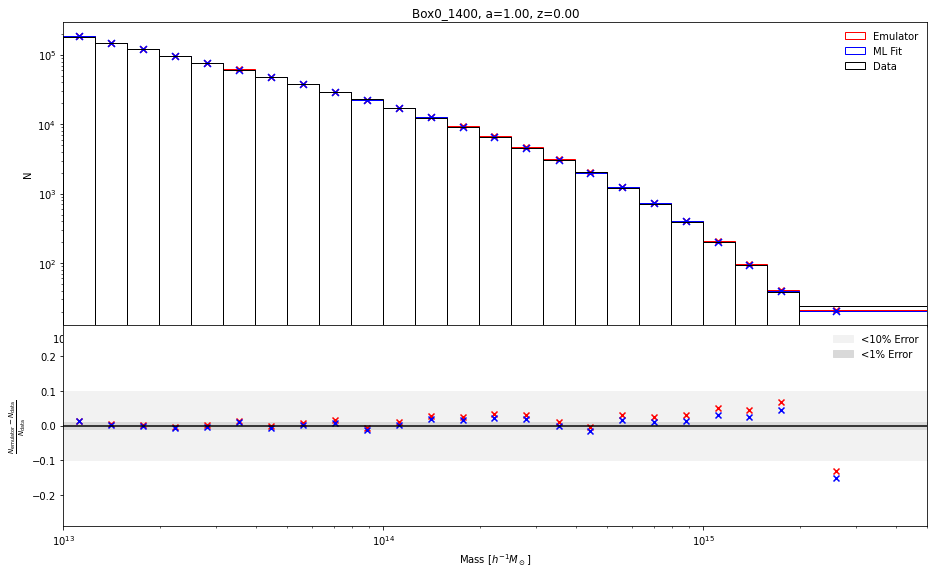

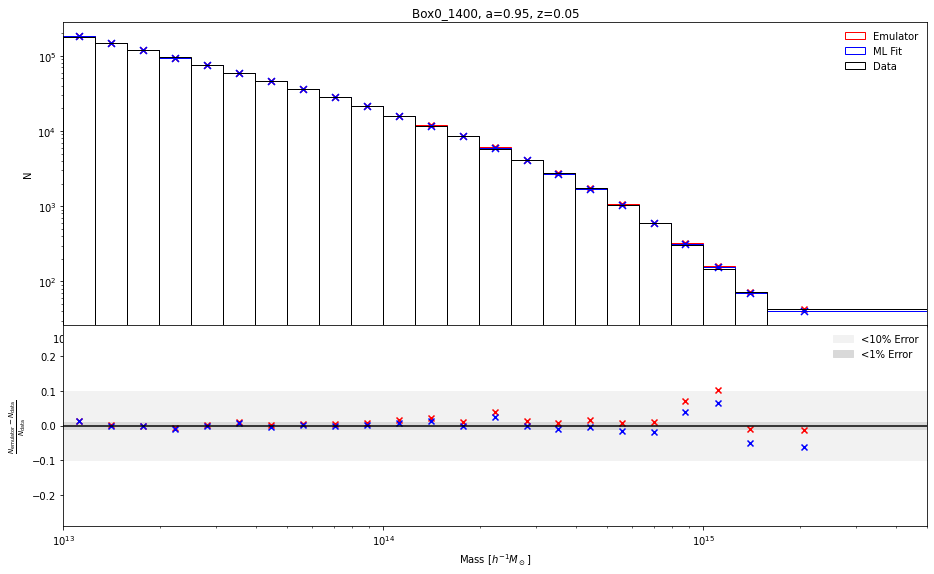

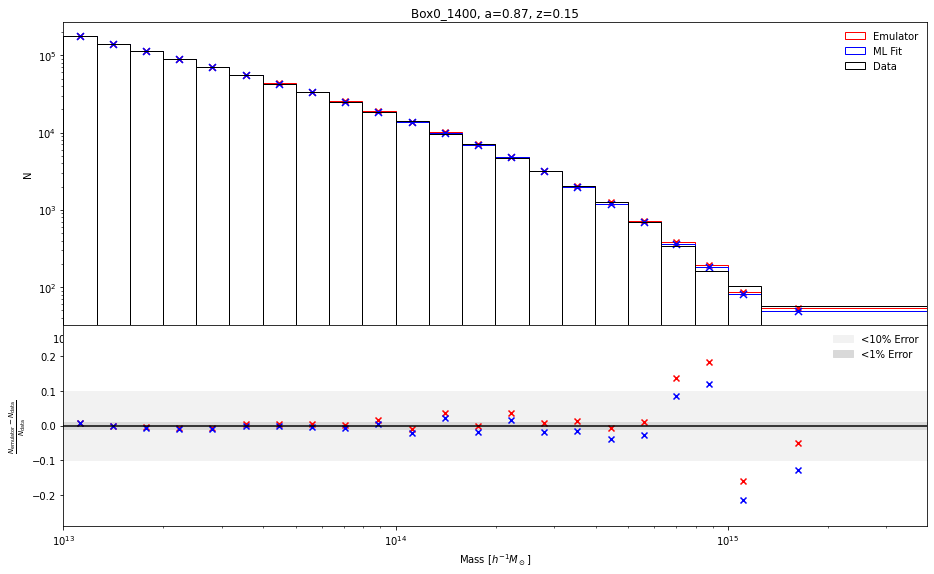

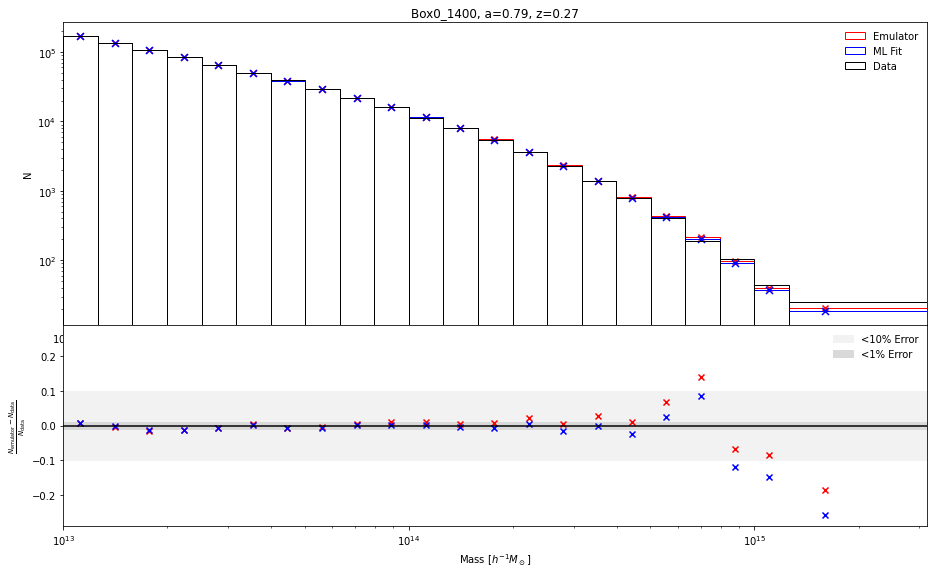

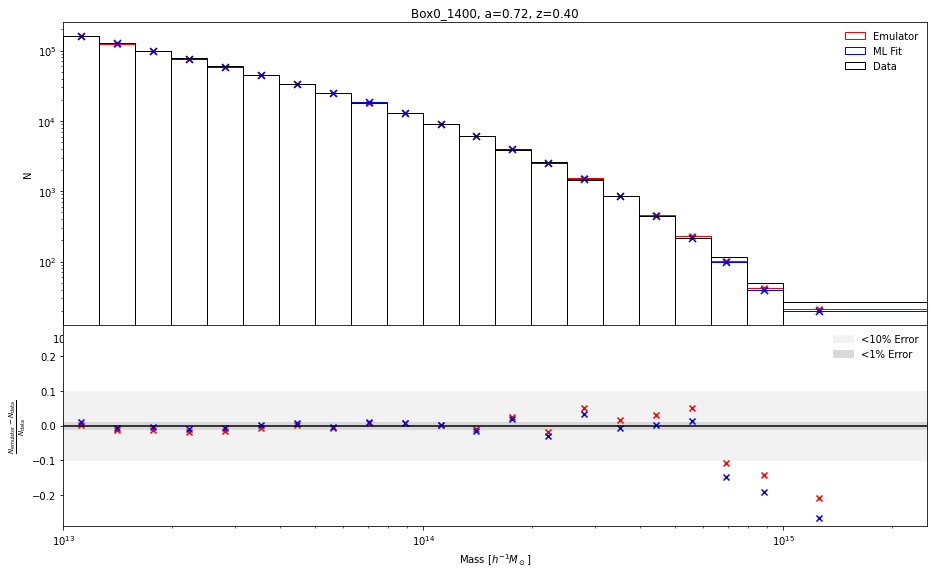

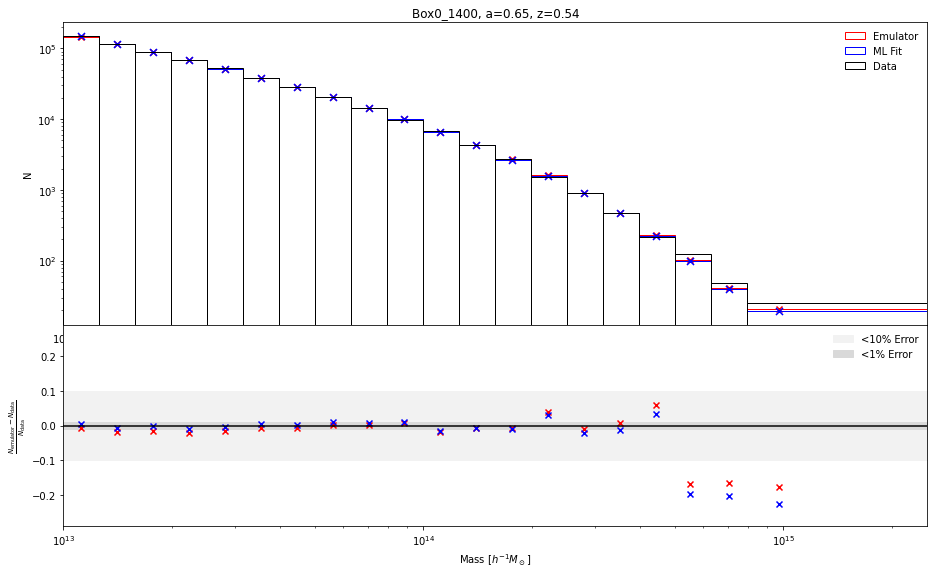

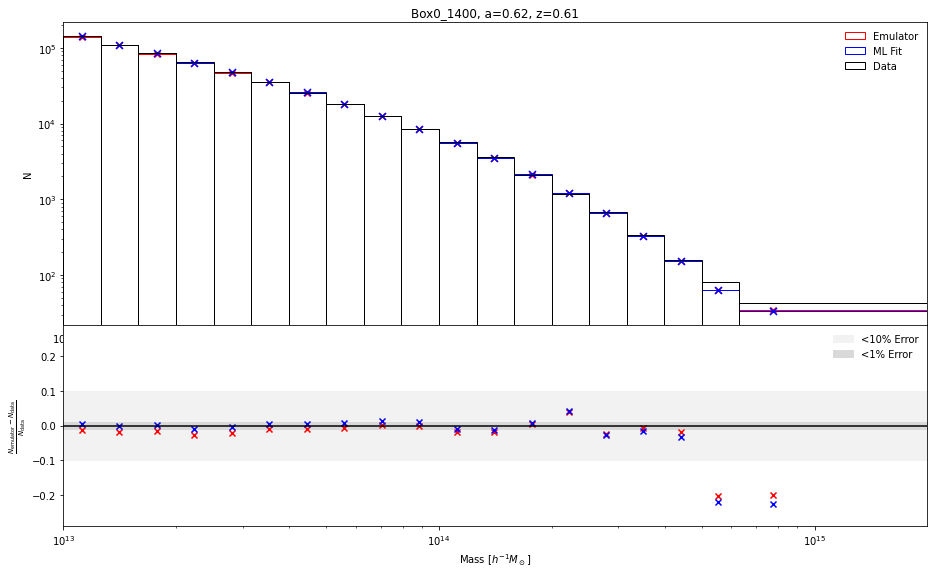

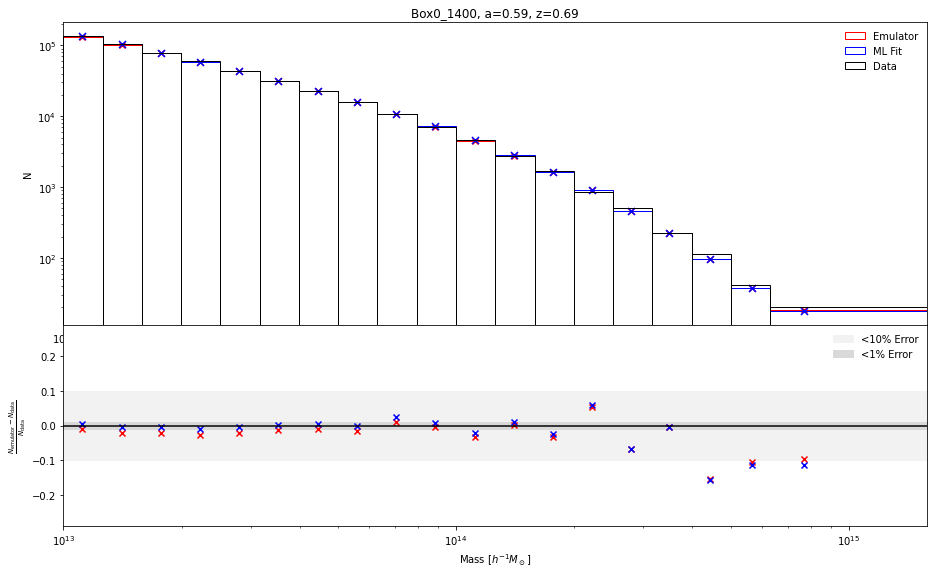

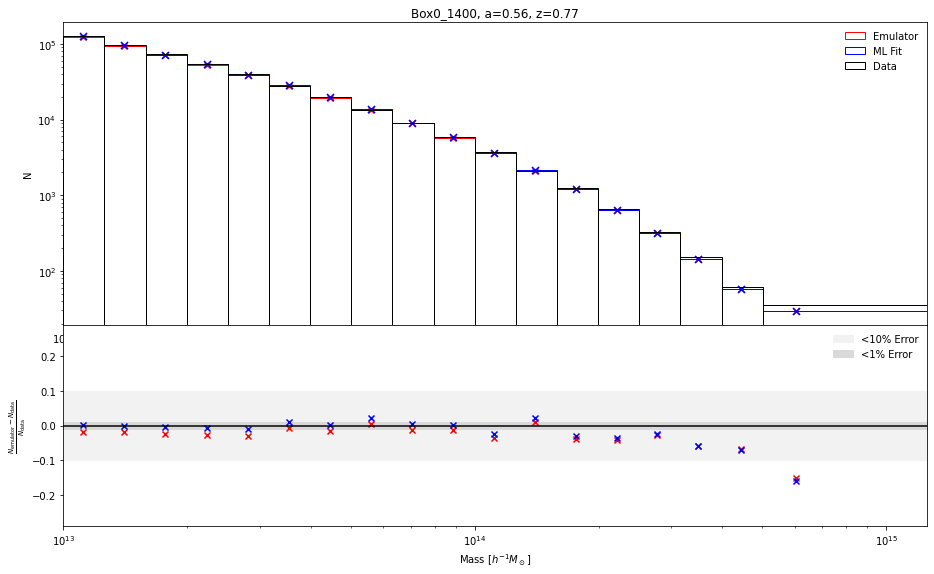

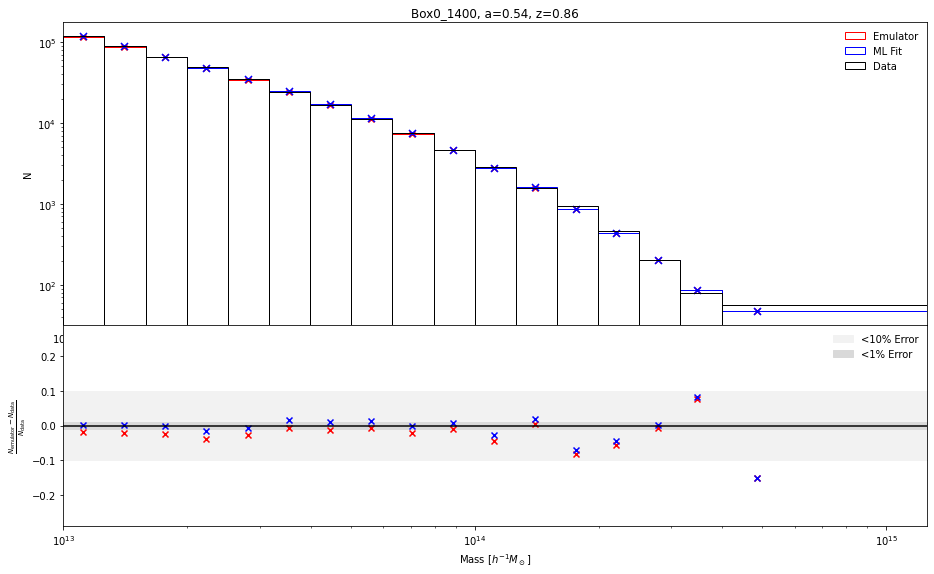

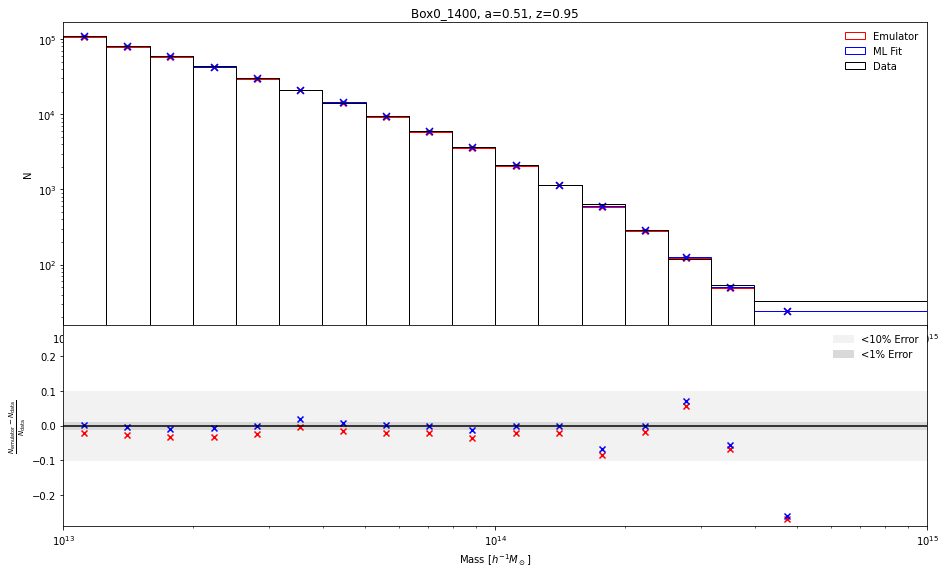

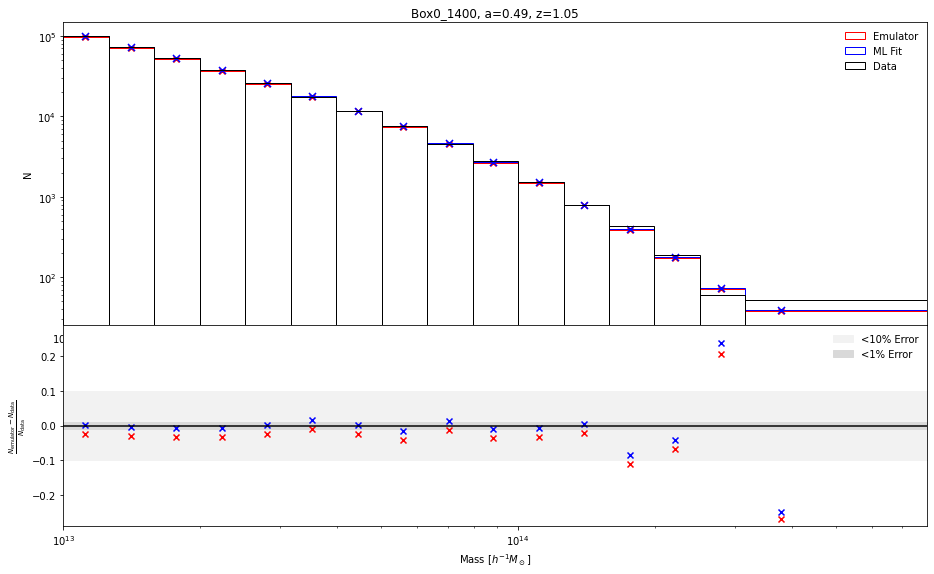

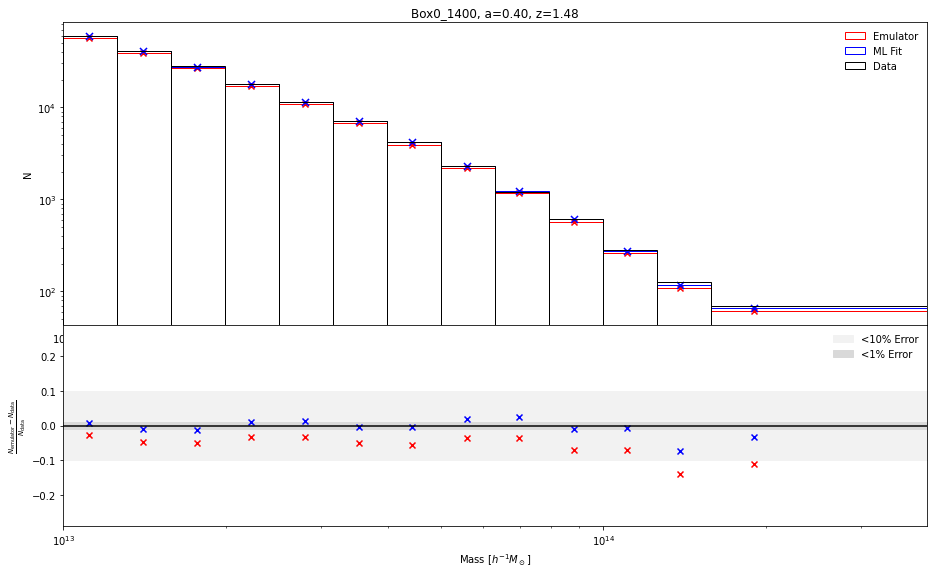

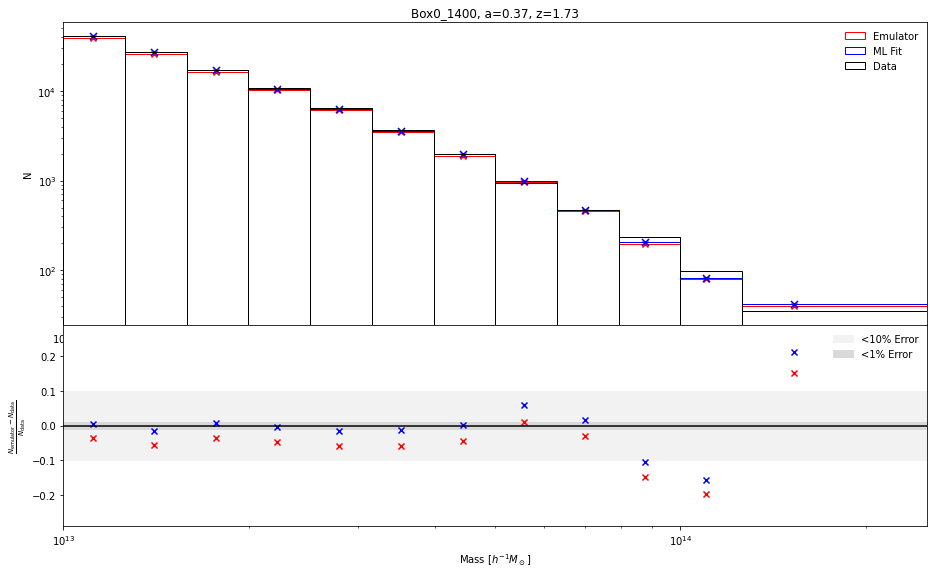

In [13]:
for a in tqdm(a_list):
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    tinker_eval_MCMC = [Emulator.predict_dndM(cosmo_params[leave_out_box], scaleToRedshift(a), M_c)*vol for M_c in M_numerics]
    f_dNdM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear',
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='red')
#     axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='red')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    #ML Fit

    c_params = dict(zip(param_names, true_params[a]))
    tinker_eval_MCMC = [Emulator.get_massfunction(cosmo_params[leave_out_box]).dndM(a, M_c, **c_params,)*vol for M_c in M_numerics]
    f_dNdM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    
    
    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_emu_loo_predicted_params.pkl"%(leave_out_box), "wb") as f:
    pickle.dump(Emulator.predict_params(cosmo_params[leave_out_box], scaleToRedshift(a)), f)